# Create Figure 3 and its variants 
Triangle plots showing all combinations of start/end year trends

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats as sstats
import os
import re
import glob
import string
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import cmocean
from tqdm.notebook import tqdm
import warnings

from funcs_support import get_filepaths,get_params,utility_print,printRoman,id_timeframe
from funcs_load import load_raws
dir_list = get_params()

In [2]:
# Load model and obs data
dss = {exp:load_raws({'varname':'prtrends','suffix':'HoAfrica','exp':exp},
                  source_dir = 'proc',force_load = True,
                    treat_multiple = {'time':'earliest'},
                     subset_params = {'start_year':slice(1981,2022),
                                      'end_year':slice(1982,2023)})
       for exp in ['amip','hist-ssp245','hist-none','obs','hindcastsf']}

In [3]:
# Bring in models for whom there is only historical, 
# not SSP2.45 data
for mod in dss['hist-none']:
    if mod in dss['hist-ssp245']:
        runs_to_concat = [run for run in dss['hist-none'][mod].run.values
                          if run not in dss['hist-ssp245'][mod].run]
        if len(runs_to_concat)>0:
            dss['hist-ssp245'][mod] = xr.concat([dss['hist-ssp245'][mod],
                                                 dss['hist-none'].sel(run=runs_to_concat)],
                                                 dim='run')
    else:
        dss['hist-ssp245'][mod] = dss['hist-none'][mod]   
del dss['hist-none']

In [4]:
# Concatenate into single dataset
def prep_for_concat(ds):
    # Helps make concatenation easier, because now the names of the runs
    # don't matter anymore (because we're not matching within models)
    ds['run'] = np.arange(0,ds.sizes['run'])
    return ds

dss = {exp:xr.concat([prep_for_concat(ds) for mod,ds in dss[exp].items()],
                dim = pd.Index([mod for mod in dss[exp]],name='model'))
       for exp in dss}

In [5]:
# Make sure to only keep the necessary variables (some obs products
# have more) 
vars_keep = ['prtrend','pr_std','trend_length','pr_tsslope','pr_iqr']

# trend_length gets broadcasted; cut it back down to size
for exp in dss:
    dss[exp] = dss[exp][vars_keep]
    dss[exp]['trend_length'] = dss[exp]['trend_length'].isel({k:0 for k in dss[exp].trend_length.sizes
                                                              if k not in ['start_year','end_year']},
                                                             drop=True)

In [6]:
# Get number of runs per model, at least during the Rowell period 
for exp in dss:
    dss[exp]['nruns'] = ((~np.isnan(dss[exp].prtrend.sel(start_year=1986,end_year=2004))).sum('run').
                         max(('season')))

In [7]:
# Get rid of models with no data
for exp in dss:
    dss[exp] = dss[exp].where((~(np.isnan(dss[exp].prtrend.sel(season='MAM',region='HoA-bimod',drop=True)).
                                      all(('run','start_year','end_year')))),drop=True)

In [8]:
# Remove CHIRPSv3, if present - not published data yet
dss['obs'] = dss['obs'].sel(model = [mod for mod in dss['obs'].model.values if mod != 'CHIRPSv3'])

In [9]:
# Subset to just LEs (more than 10 runs, here)
dss_les = {exp:ds.where(ds.nruns>=10,drop=True) for exp,ds in dss.items()}
# Add obs back in to make it easy (obs is dropped because 1 run per product)
dss_les['obs'] = dss['obs']

In [10]:
# Get short and medium-term lead times for hindcasts
dss['hindcasts05lead'] = dss['hindcastsf'].sel(lead=0.5,drop=True)
dss['hindcasts1-3lead'] = dss['hindcastsf'].sel(lead=[1.5,2.5,3.5]).mean('lead')


## Plot code

In [11]:
def percentileof_alongdim(da,da_score,nan_policy='omit'):
    ''' apply_ufunc-compatible wrapper of percentileofscore
    '''
    
    return sstats.percentileofscore(da.flatten(),
                                    da_score,
                                    nan_policy=nan_policy)*0.01

In [12]:
def plot_triangle(ds_field,ds_hatch,
                  nruns = None,
                  season = 'MAM',
                  region = 'HoA-bimod',
                  plot_type = 'levels',
                  hatch_lims = [0.05,0.95],
                  cbar_params = {'vmin':-0.15,'vmax':0.15,'cmap':cmocean.cm.balance_r,'levels':21},
                  add_colorbar = False,
                  add_annotation=False,
                  trend_guide_spacing = 10,# or None
                  label_trend_guide = False,
                  factor = 10,
                  fig = None,
                  ax = None,
                  year_lims = None, # otherwise dict piped into .sel()
                  # 'all' = years where every field and hatch model has data
                  # 'any' = years where at least 1 field _and_ 1 hatch product has data 
                  # None = skip this step
                  year_subset = 'all'):
                  
    #------------- Gather data -------------
    plot_data = {'field':ds_field,'hatch':ds_hatch}

    if plot_type == 'levels':
        var_list = ['prtrend']
    elif plot_type == 'cv':
        var_list = ['prtrend','pr_std']
    elif plot_type == 'tslevels':
        var_list = ['pr_tsslope']
    elif plot_type == 'tscv':
        var_list = ['pr_tsslope','pr_iqr']
    else:
        raise ValueError(plot_type+' is not a valid plot_type.')

    # Subset to season, region
    plot_data = {typ:ds.sel(season=season,region=region,drop=True)[var_list]*factor
               for typ,ds in plot_data.items()}

    # Subset manually to specific years, if desired
    if year_lims is not None:
        plot_data = {typ:ds.sel(**year_lims) for typ,ds in plot_data.items()}

    # Subset dynamically to years with data, if desired
    if year_subset is not None:
        with warnings.catch_warnings():
            # Ignores depreciation warning from numpy product of creating array 
            # from ragged lists... 
            warnings.filterwarnings('ignore')
            
            for typ in plot_data:
                for dim in ['run','model']:
                    if dim not in plot_data[typ].sizes:
                        plot_data[typ] = plot_data[typ].expand_dims({dim:['0']})
            
            if year_subset == 'all':
                keep_matrix = xr.concat([(~np.isnan(ds[var_list[0]])).any('run').all('model')
                                             for typ,ds in plot_data.items()],
                                          dim='typ').prod('typ').astype(bool)
            elif year_subset == 'any':
                keep_matrix = xr.concat([(~np.isnan(ds[var_list[0]])).any('run').any('model')
                                             for typ,ds in plot_data.items()],
                                          dim='typ').prod('typ').astype(bool)

            plot_data = {typ:ds.where(keep_matrix,drop=True) for typ,ds in plot_data.items()}

    # Subset by number of runs, if desired
    if nruns is not None:
        for typ in plot_data:
            for var in var_list:
                if 'run' in plot_data[typ][var].sizes:
                    plot_data[typ][var] = (plot_data[typ][var].to_dataframe().dropna().
                                 groupby(['model','start_year','end_year']).head(nruns).
                                 to_xarray()[var])

                    plot_data[typ][var] = plot_data[typ][var].dropna(dim='run',how='all')

    # Average across model, run in field variable if sizes > 0 
    plot_data['field'] = plot_data['field'].mean([dim for dim in ['model','run'] if dim in plot_data['field'].sizes])

    for typ in plot_data:
        if plot_type in ['levels','tslevels']:
            plot_data[typ] = plot_data[typ][var_list[0]]
        elif plot_type in ['cv','tscv']:
            plot_data[typ] = plot_data[typ][var_list[0]] / plot_data[typ][var_list[1]]
            plot_data[typ] = plot_data[typ]*factor # This otherwise gets divided out

    # Subset to only start/end years that both arrays have
    plot_data = {typ:ds.sel(**{yrtyp:[yr for yr in plot_data['hatch'][yrtyp].values if yr in plot_data['field'][yrtyp]]
                          for yrtyp in ['start_year','end_year']})
                 for typ,ds in plot_data.items()}
            
    #------------- Get hatching -------------
    # Stack hatch variable into one model-run 
    # dimension for %ile calc
    plot_data['hatch'] = plot_data['hatch'].stack(modrun = ('model','run'))

    # Get what %ile of the hatch distribution
    # the field distribution is 
    pcts = xr.apply_ufunc(percentileof_alongdim,
                          plot_data['hatch'],
                          plot_data['field'],
                          input_core_dims = [['modrun'],[]],
                          vectorize=True)

    # Get hatching flag
    hatching = (pcts < np.min(hatch_lims)) | (pcts > np.max(hatch_lims))

    # Make sure hatching leaves the stuff blank it should
    hatching = hatching.where(~np.isnan(plot_data['field']))

    #------------- Plot -------------
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = plt.subplot()

    # Shade observations
    plot_data['field'].plot.contourf(x='start_year',**cbar_params,add_colorbar=False,ax=ax)
    # Add 0 line
    plot_data['field'].plot.contour(x='start_year',levels=[0],colors=['grey'],ax=ax)

    # Add hatching for obs outside of CMIP6 AMIP quantiles
    (hatching.plot.contourf(levels=[-1,0],hatches=[None,'///'],cmap='none',add_colorbar=False,
                   x='start_year',ax=ax))

    # Add a dividing line if the last year is before the graph
    # edges (for AMIP, for example, where obs goes beyond) 
    if hatching.end_year.max()<plot_data['field'].end_year.max():
        ax.axhline(hatching.end_year.max(),color='k',linestyle='--')
        if (col_idx == 0):
            ax.annotate('Model limit',(plot_data['field'].start_year.max()-1,hatching.end_year.max()),
                        (plot_data['field'].start_year.max()-1,hatching.end_year.max()-5),ha='right',va='top',
                        arrowprops={'arrowstyle':'->','relpos':(0.5,0.5)},
                        rotation=270)


    #------------- Annotate -------------

    ax.set_xlabel('Trend start year')
    ax.set_ylabel('Trend end year')

    if add_annotation:
        ann_params = {'xy':[0.975,0.005],
                          'va':'bottom'}
        ax.annotate('Hatching: outside of \n'+'-'.join([str(q) for q in qs])+' range',
                    xycoords='axes fraction',ha='right',**ann_params)


    ax.set_aspect('equal')

    # Add trend length guidance
    if trend_guide_spacing is not None:
        lims = ax.get_xlim()
        guide_lines = [[[lims[0],lims[1]-(guide_idx*trend_guide_spacing)],
                         [lims[0]+(guide_idx*trend_guide_spacing),lims[1]]]
                       for guide_idx in np.arange(1,np.diff(lims)[0]/trend_guide_spacing)]
        for guide_idx in range(0,len(guide_lines)):
            ax.plot(*guide_lines[guide_idx],color='grey',linewidth=0.5)
    
        # Now set tick labels with trend length
        if label_trend_guide:
            ax_tmp = ax.secondary_xaxis('top')
            ax_tmp.set_xticks([gl[0][1] for gl in guide_lines],
                             labels=[str(int((guide_idx*trend_guide_spacing)))+' yrs'
                                       for guide_idx in np.arange(1,np.diff(lims)[0]/trend_guide_spacing)],
                              rotation=45,ha='left')
            ax_tmp.tick_params(axis='x',top=False,pad=-2)

    if add_colorbar:
        # Vertical colorbar
        fig.subplots_adjust(right=0.825)
        cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
        levels = mpl.ticker.MaxNLocator(nbins=cbar_params['levels']).tick_values(cbar_params['vmin'],cbar_params['vmax'])
        norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params['cmap'].N ,extend='both')
        sm = plt.cm.ScalarMappable(cmap=cbar_params['cmap'],norm=norm)
        plt.colorbar(sm,cax=cax,label=clabel)

    #------------- Return -------------
    return fig,ax

In [13]:
def plot_triangles(dss,
                   exps = ['hist-ssp245','amip'],
                   obs_mods = 'auto', # or list of models
                   lims = [1980,2022],
                   seas = 'MAM',
                   label_trend_guide = True,
                   trend_guide_spacing = 10,
                   ncol = 5,
                   figsize = (20,15),
                   cbar_params = {'vmin':-1.5,'vmax':1.5,
                       'cmap':cmocean.cm.balance_r,'levels':21},
                   plot_type = 'levels', # or cv, tslevels, tscv
                   exp_titles = {'hist-ssp245':r'CMIP6\ (Hist\ /\ SSP245)','amip':'AMIP6',
                                 'hindcasts05lead':r'0.5-month\ lead','hindcasts1-3lead':r'1.5-3.5-month\ lead'},
                   year_subset = 'all',
                   save_fig = False,
                   output_fn = None):
                
    if (type(obs_mods) == str) and (obs_mods == 'auto'):
        obs_mods = dss['obs'].model.values

    #------- Create figure -------
    nrows = ((len(obs_mods)-1) // ncol + 1) * len(exps) 
    nrows = nrows + int((nrows / len(exps)) - 1)
    height_ratios = np.ones(nrows)
    height_ratios[np.arange(0,nrows)[len(exps)::(len(exps)+1)]] = 0.1


    fig,axs = plt.subplots(nrows,ncol,
                           figsize=figsize,
                           gridspec_kw={'height_ratios':height_ratios}
                            )

    #------- Set plot data -------
    ax_params = [[{'ds_field':dss['obs'].sel(model=obs_mod),'ds_hatch':dss[exp],'season':seas,'plot_type':plot_type}
                 for obs_mod in obs_mods] for exp in exps]

    if plot_type == 'levels':
        clabel = r'$P$ trend [mm/day/10yr]'
    elif plot_type == 'cv':
        clabel = r'$P$ trend [Trend/10yr/SD]'
    elif plot_type == 'tslevels':
        clabel = r'$P$ Theil-Sen slope [mm/day/10yr]'
    elif plot_type == 'tscv':
        clabel = r'$P$ Theil-Sen slope [Trend/10yr/IQR]'

    for exp_idx in np.arange(0,len(exps)):
        for mod_idx in np.arange(0,len(obs_mods)):
            #for plt_idx in np.arange(0,len(ax_params)):

            #--------- Plot location ---------
            # Get row index
            row_idx = (mod_idx // ncol)*len(exps) + exp_idx
            # Add offset for dummy axis in the middle 
            row_idx = row_idx + mod_idx // ncol

            # Column index
            col_idx = mod_idx % ncol

            if (row_idx == 0) and (label_trend_guide):
                ex_params = {'label_trend_guide':True}
            else:
                ex_params = {}

            fig,axs[row_idx,col_idx] = plot_triangle(**ax_params[exp_idx][mod_idx],year_subset = 'any',
                                             fig=fig,ax=axs[row_idx,col_idx],cbar_params = cbar_params,
                                                     trend_guide_spacing = trend_guide_spacing,
                                                    **ex_params)


            # Axis lettering
            if exp_idx == 0:
                axs[row_idx,col_idx].set_title(r'$\mathbf{'+str(ax_params[exp_idx][mod_idx]['ds_field'].model.values)+'}$',fontsize=12)

            if (exp_idx == (len(exps)-1)) and ((row_idx == (nrows - 1)) or 
                                              ((row_idx == (nrows - len(exps) - 2)) and 
                                               (col_idx >= (len(obs_mods) % ncol)))):
                axs[row_idx,col_idx].set_xlabel('Trend start year',fontsize=12)
            else:
                axs[row_idx,col_idx].set_xlabel('')

            if (mod_idx % ncol) == 0:
                axs[row_idx,col_idx].set_ylabel(r'$\mathbf{'+exp_titles[exps[exp_idx]]+'}$'+'\nTrend end year',fontsize=12)
            else:
                axs[row_idx,col_idx].set_ylabel('')

            # Subplot lettering
            if len(obs_mods)*ncol <= 26:
                sp_id = string.ascii_lowercase[(ncol*row_idx)+col_idx]
            else:
                sp_id = printRoman((ncol*row_idx)+col_idx + 1).lower()
            if label_trend_guide and (row_idx == 0):
                pos = [-0.05,1.01]
            else:
                pos = [0.01,1.01]
            axs[row_idx,col_idx].annotate(sp_id+'.',
                                pos,xycoords='axes fraction',
                                va='bottom',ha='left',fontsize=12,fontweight='bold')

            # Axis parameters
            if np.diff(lims)<50:
                tick_spacing = 10
            else:
                tick_spacing = 20
            axs[row_idx,col_idx].set_yticks(np.arange(lims[0],lims[1],tick_spacing))
            axs[row_idx,col_idx].set_xticks(np.arange(lims[0],lims[1],tick_spacing))
            axs[row_idx,col_idx].set_xlim(lims)
            axs[row_idx,col_idx].set_ylim(lims)
            axs[row_idx,col_idx].grid()
            # Grid parameters
            if (mod_idx % ncol) == 0:
                axs[row_idx,col_idx].tick_params(axis='y', which='both',left=True,labelleft=True)
            elif (mod_idx % ncol) == (ncol - 1):
                axs[row_idx,col_idx].tick_params(axis='y',which='both',right=True,labelright=True,left=False,labelleft=False)
            else:
                axs[row_idx,col_idx].tick_params(axis='y', which='both',left=False,labelleft=False)

            if (exp_idx == (len(exps)-1)) and ((row_idx == (nrows - 1)) or 
                                              ((row_idx == (nrows - len(exps) - 2)) and 
                                               (col_idx >= (len(obs_mods) % ncol)))):
                axs[row_idx,col_idx].tick_params(axis='x',which='both',bottom=True,labelbottom=True)
            else:
                axs[row_idx,col_idx].tick_params(axis='x',which='both',bottom=False,labelbottom=False)

    #--------- Additional annotations ---------
    # Add legend
    axs[0,0].legend(handles=[mpatches.Patch(facecolor=cmocean.cm.balance_r(80), edgecolor=cmocean.cm.balance_r(80),
                             label='Obs. trends'),
                           mpatches.Patch(facecolor='w',edgecolor='k',hatch='\\\\\\',
                                          label='Obs. outside of\n90% of models/runs')],
                  loc='lower right',fontsize='small')

    # Vertical colorbar
    fig.subplots_adjust(right=0.825)
    cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
    levels = mpl.ticker.MaxNLocator(nbins=cbar_params['levels']).tick_values(cbar_params['vmin'],cbar_params['vmax'])
    norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params['cmap'].N, clip=True)
    sm = plt.cm.ScalarMappable(cmap=cbar_params['cmap'],norm=norm)
    cb = plt.colorbar(sm,cax=cax)
    cb.ax.tick_params(labelsize=15) 
    cb.set_label(clabel,fontsize=15)


    # Blank out rows
    blank_rows = ((len(exps)+1) * np.arange(0,len(obs_mods) // ncol + 1) - 1)
    blank_rows = blank_rows[(blank_rows > 0) & (blank_rows < nrows)]
    for row_idx in blank_rows: 
        for col_idx in np.arange(0,ncol):
            axs[row_idx,col_idx].set_axis_off()

            # Add line visually separating the two sets of rows
            #axs[row_idx,col_idx].plot([-0.5,1.5],[0.25,0.25], clip_on=False,#transform=axs[row_idx,col_idx].transAxes
            #          linewidth=2, color='k')

    # Blank out panels in rows at the end 
    if len(obs_mods) % ncol != 0:
        for col_idx in np.arange(len(obs_mods) % ncol, ncol):
            for row_idx in np.arange((len(axs)-len(exps)),len(axs)):
                axs[row_idx,col_idx].set_visible(False)



    #--------- Save ---------
    if save_fig:
        utility_print(output_fn)

## Main text Figure 3
Using the average of CHIRPS, GPCC (full), and GPCP as the "obs"

### Upper half panel (CMIP6 models)

/dx02/kschwarz/project_data/future_stability/figures/figure3a.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figure3a.png saved!


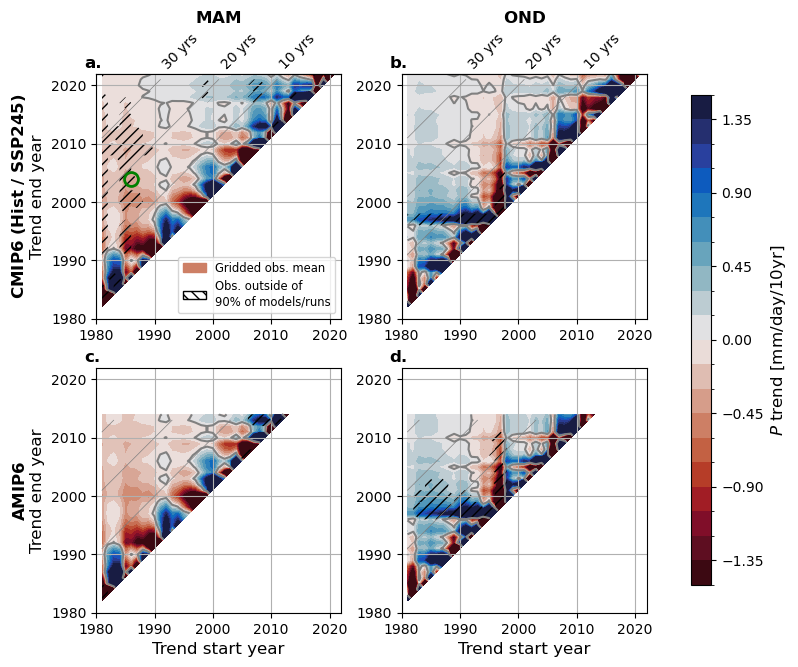

In [14]:
save_fig = True
output_fn = dir_list['figs']+'figure3a'
plot_type = 'levels'

smods = ['GPCP','CHIRPS','GPCC-full']
smod_str = 'Gridded obs. mean' #str(ax_params[0]['ds_field'].model.values)+' obs.')

lims = [1980,2022]

fig = plt.figure(figsize=(8,7))

ax_params = [{'ds_field':dss['obs'].sel(model=smods).mean('model'),'ds_hatch':dss['hist-ssp245'],'season':'MAM'},
             {'ds_field':dss['obs'].sel(model=smods).mean('model'),'ds_hatch':dss['hist-ssp245'],'season':'OND'},
             {'ds_field':dss['obs'].sel(model=smods).mean('model'),'ds_hatch':dss['amip'],'season':'MAM'},
             {'ds_field':dss['obs'].sel(model=smods).mean('model'),'ds_hatch':dss['amip'],'season':'OND'}]
for ap in ax_params:
    ap['trend_guide_spacing'] = 10
ax_params[0]['label_trend_guide'] = ax_params[1]['label_trend_guide'] = True

cbar_params = {'vmin':-1.5,'vmax':1.5,
               'cmap':cmocean.cm.balance_r,'levels':21}
if plot_type == 'levels':
    clabel = r'$P$ trend [mm/day/10yr]'
elif plot_type == 'cv':
    clabel = r'$P$ trend [Trend/10yr/SD]'
exp_titles = [r'CMIP6\ (Hist\ /\ SSP245)','','AMIP6','']

axs = [None]*len(ax_params)
for plt_idx in np.arange(0,len(ax_params)):
    axs[plt_idx] = plt.subplot(2,2,plt_idx+1)
    fig,axs[plt_idx] = plot_triangle(**ax_params[plt_idx],year_subset = 'any',
                                     fig=fig,ax=axs[plt_idx],cbar_params = cbar_params)
    
    
    # Axis lettering
    if plt_idx < 2:
        axs[plt_idx].set_xlabel('')
        axs[plt_idx].set_title(r'$\mathbf{'+ax_params[plt_idx]['season']+'}$',fontsize=12)
    else:
        axs[plt_idx].set_xlabel('Trend start year',fontsize=12)
    if plt_idx % 2 > 0:
        axs[plt_idx].set_ylabel('')
    elif plt_idx % 2 == 0:
        axs[plt_idx].set_ylabel(r'$\mathbf{'+exp_titles[plt_idx]+'}$'+'\nTrend end year',fontsize=12)
        
    # Subplot lettering
    axs[plt_idx].annotate(string.ascii_lowercase[plt_idx]+'.',
                        [-0.05,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=12,fontweight='bold')
    
    # Axis parameters
    axs[plt_idx].set_yticks(np.arange(lims[0],lims[1],10))
    axs[plt_idx].set_xticks(np.arange(lims[0],lims[1],10))
    axs[plt_idx].set_xlim(lims)
    axs[plt_idx].set_ylim(lims)
    axs[plt_idx].grid()

    
#--------- Additional annotations ---------
# Add Rowell 2015 point
axs[0].plot([1986],[2004],'og',fillstyle='none',
            markeredgewidth=2,markersize=10)

# Add legend
axs[0].legend(handles=[mpatches.Patch(facecolor=cmocean.cm.balance_r(80), edgecolor=cmocean.cm.balance_r(80),
                         label=smod_str),
                       mpatches.Patch(facecolor='w',edgecolor='k',hatch='\\\\\\',
                                      label='Obs. outside of\n90% of models/runs')],
              loc='lower right',fontsize='small')

# Vertical colorbar
fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
levels = mpl.ticker.MaxNLocator(nbins=cbar_params['levels']).tick_values(cbar_params['vmin'],cbar_params['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=cbar_params['cmap'],norm=norm)
cb = plt.colorbar(sm,cax=cax)
cb.set_label(clabel,fontsize=12)

#--------- Save ---------
if save_fig:
    utility_print(output_fn)

### Lower half panel (NMME models)

/dx02/kschwarz/project_data/future_stability/figures/figure3b.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figure3b.png saved!


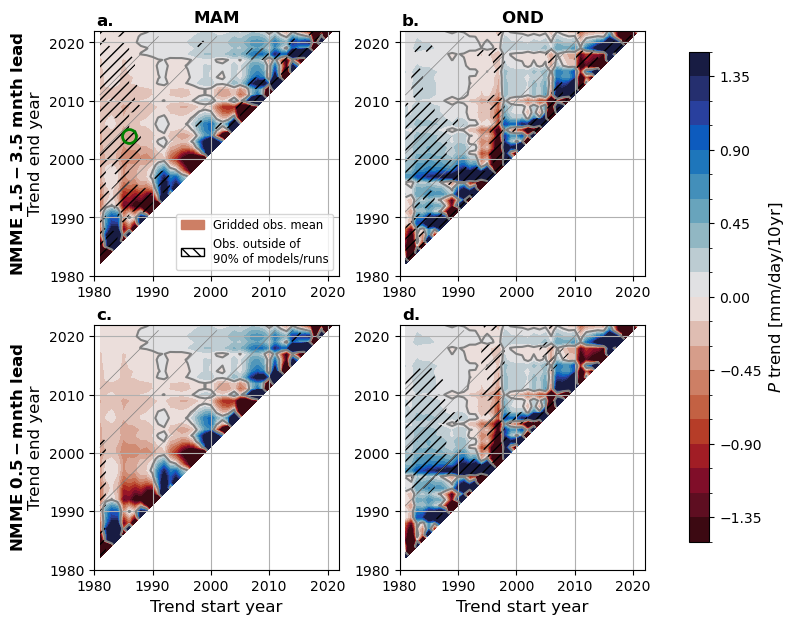

In [15]:
save_fig = True
output_fn = dir_list['figs']+'figure3b'
plot_type = 'levels'

smods = ['GPCP','CHIRPS','GPCC-full']
smod_str = 'Gridded obs. mean' #str(ax_params[0]['ds_field'].model.values)+' obs.')

lims = [1980,2022]

fig = plt.figure(figsize=(8,7))

ax_params = [{'ds_field':dss['obs'].sel(model=smods).mean('model'),'ds_hatch':dss['hindcasts1-3lead'],'season':'MAM'},
             {'ds_field':dss['obs'].sel(model=smods).mean('model'),'ds_hatch':dss['hindcasts1-3lead'],'season':'OND'},
             {'ds_field':dss['obs'].sel(model=smods).mean('model'),'ds_hatch':dss['hindcasts05lead'],'season':'MAM'},
             {'ds_field':dss['obs'].sel(model=smods).mean('model'),'ds_hatch':dss['hindcasts05lead'],'season':'OND'}]
for ap in ax_params:
    ap['trend_guide_spacing'] = 10

cbar_params = {'vmin':-1.5,'vmax':1.5,
               'cmap':cmocean.cm.balance_r,'levels':21}
if plot_type == 'levels':
    clabel = r'$P$ trend [mm/day/10yr]'
elif plot_type == 'cv':
    clabel = r'$P$ trend [Trend/10yr/SD]'
exp_titles = [r'NMME\ 1.5-3.5\ mnth\ lead','',r'NMME\ 0.5-mnth\ lead','']

axs = [None]*len(ax_params)
for plt_idx in np.arange(0,len(ax_params)):
    axs[plt_idx] = plt.subplot(2,2,plt_idx+1)
    fig,axs[plt_idx] = plot_triangle(**ax_params[plt_idx],year_subset = 'any',
                                     fig=fig,ax=axs[plt_idx],cbar_params = cbar_params)
    
    
    # Axis lettering
    if plt_idx < 2:
        axs[plt_idx].set_xlabel('')
        axs[plt_idx].set_title(r'$\mathbf{'+ax_params[plt_idx]['season']+'}$',fontsize=12)
    else:
        axs[plt_idx].set_xlabel('Trend start year',fontsize=12)
    if plt_idx % 2 > 0:
        axs[plt_idx].set_ylabel('')
    elif plt_idx % 2 == 0:
        axs[plt_idx].set_ylabel(r'$\mathbf{'+exp_titles[plt_idx]+'}$'+'\nTrend end year',fontsize=12)
        
    # Subplot lettering
    axs[plt_idx].annotate(string.ascii_lowercase[plt_idx]+'.',
                        [0.01,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=12,fontweight='bold')
    
    # Axis parameters
    axs[plt_idx].set_yticks(np.arange(lims[0],lims[1],10))
    axs[plt_idx].set_xticks(np.arange(lims[0],lims[1],10))
    axs[plt_idx].set_xlim(lims)
    axs[plt_idx].set_ylim(lims)
    axs[plt_idx].grid()
    
#--------- Additional annotations ---------
# Add Rowell 2015 point
axs[0].plot([1986],[2004],'og',fillstyle='none',
            markeredgewidth=2,markersize=10)

# Add legend
axs[0].legend(handles=[mpatches.Patch(facecolor=cmocean.cm.balance_r(80), edgecolor=cmocean.cm.balance_r(80),
                         label=smod_str),
                       mpatches.Patch(facecolor='w',edgecolor='k',hatch='\\\\\\',
                                      label='Obs. outside of\n90% of models/runs')],
              loc='lower right',fontsize='small')

# Vertical colorbar
fig.subplots_adjust(right=0.825)
cax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
levels = mpl.ticker.MaxNLocator(nbins=cbar_params['levels']).tick_values(cbar_params['vmin'],cbar_params['vmax'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cbar_params['cmap'].N, clip=True)
sm = plt.cm.ScalarMappable(cmap=cbar_params['cmap'],norm=norm)
cb = plt.colorbar(sm,cax=cax)
cb.set_label(clabel,fontsize=12)

#--------- Save ---------
if save_fig:
    utility_print(output_fn)

## Alternate versions by separate historical dataset and showing $\Delta(P) / \sigma(P)$ instead

### CMIP6 plots (Figures S5-S8)

/dx02/kschwarz/project_data/future_stability/figures/figureS11.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS11.png saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS12.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS12.png saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS13.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS13.png saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS14.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS14.png saved!


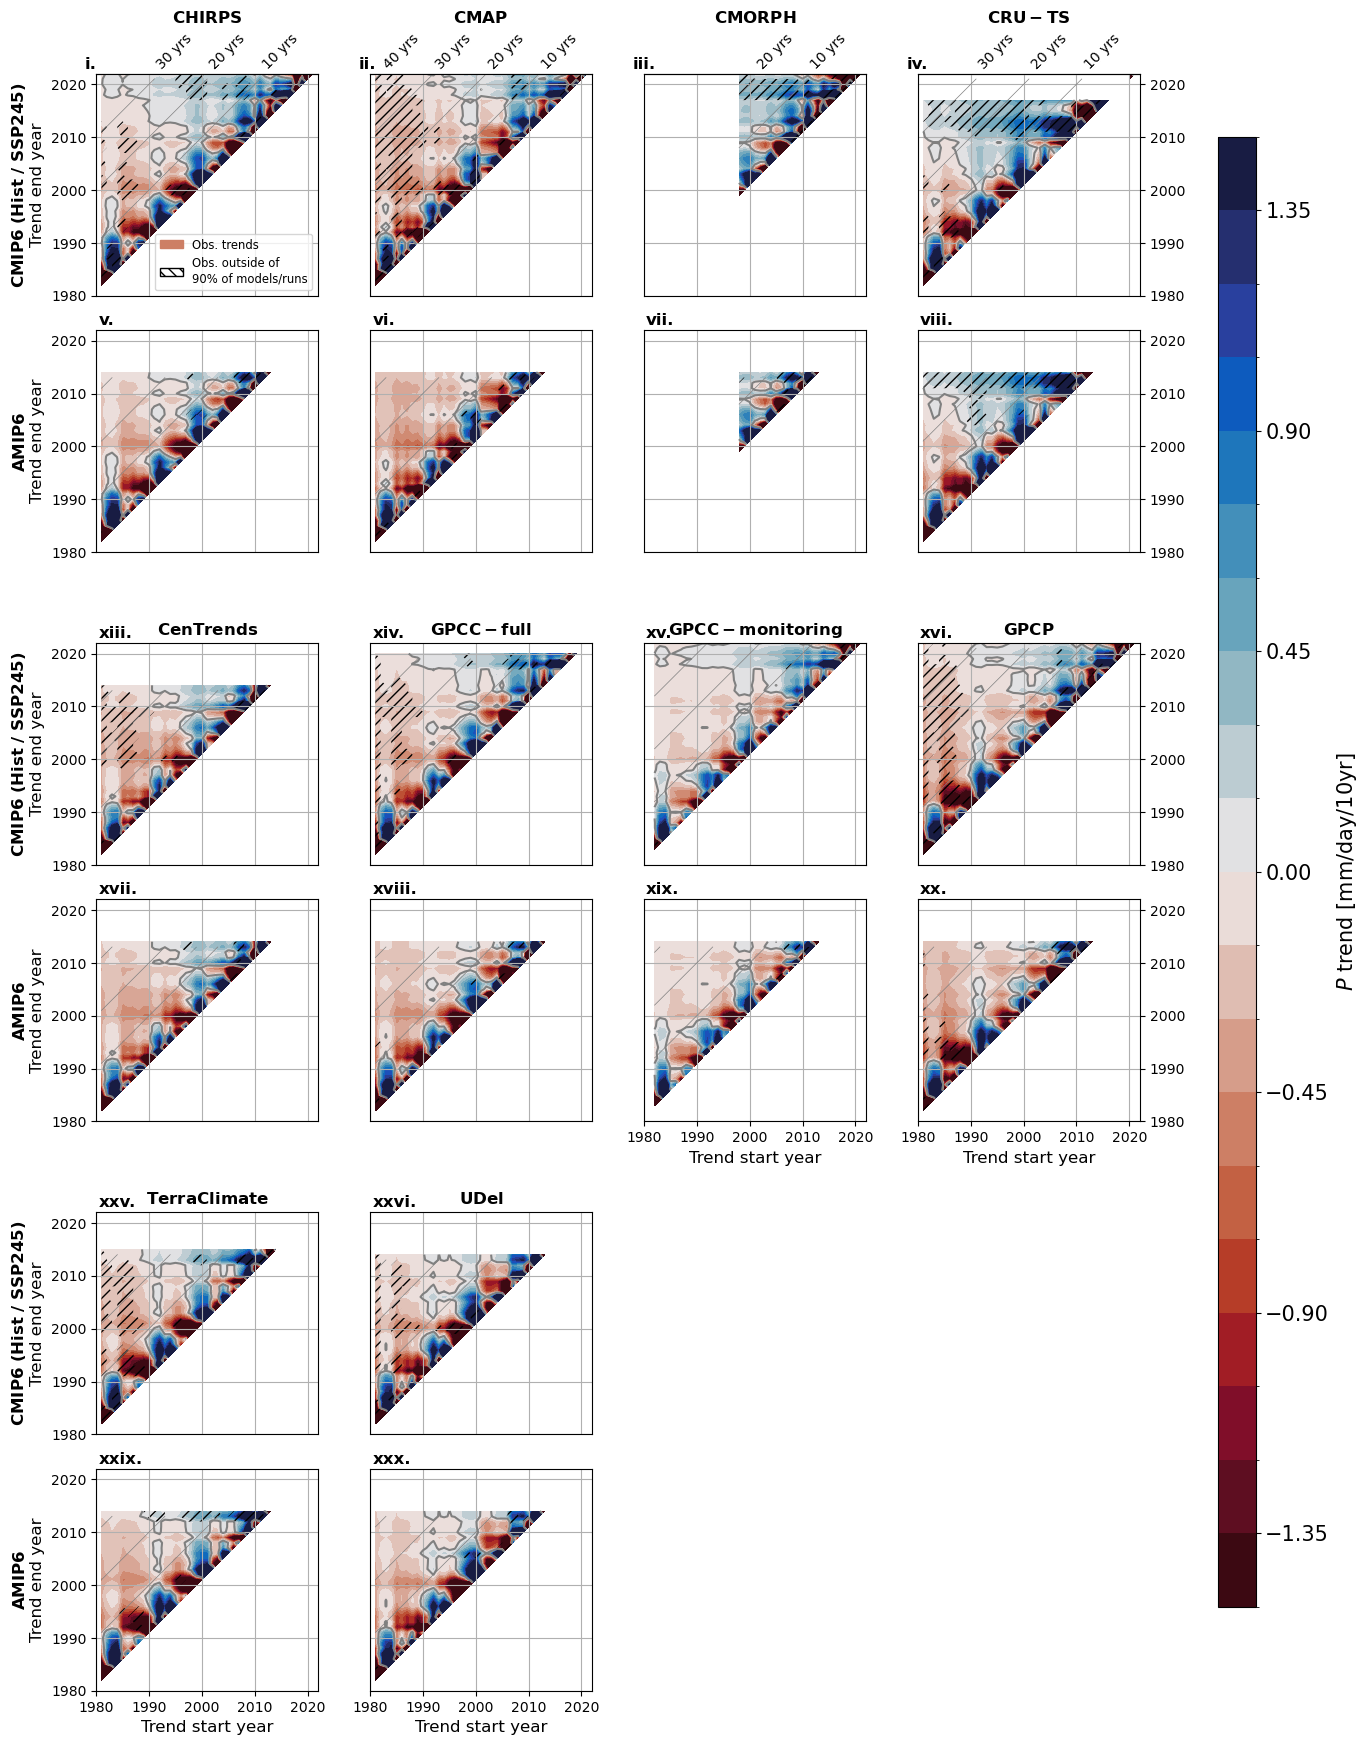

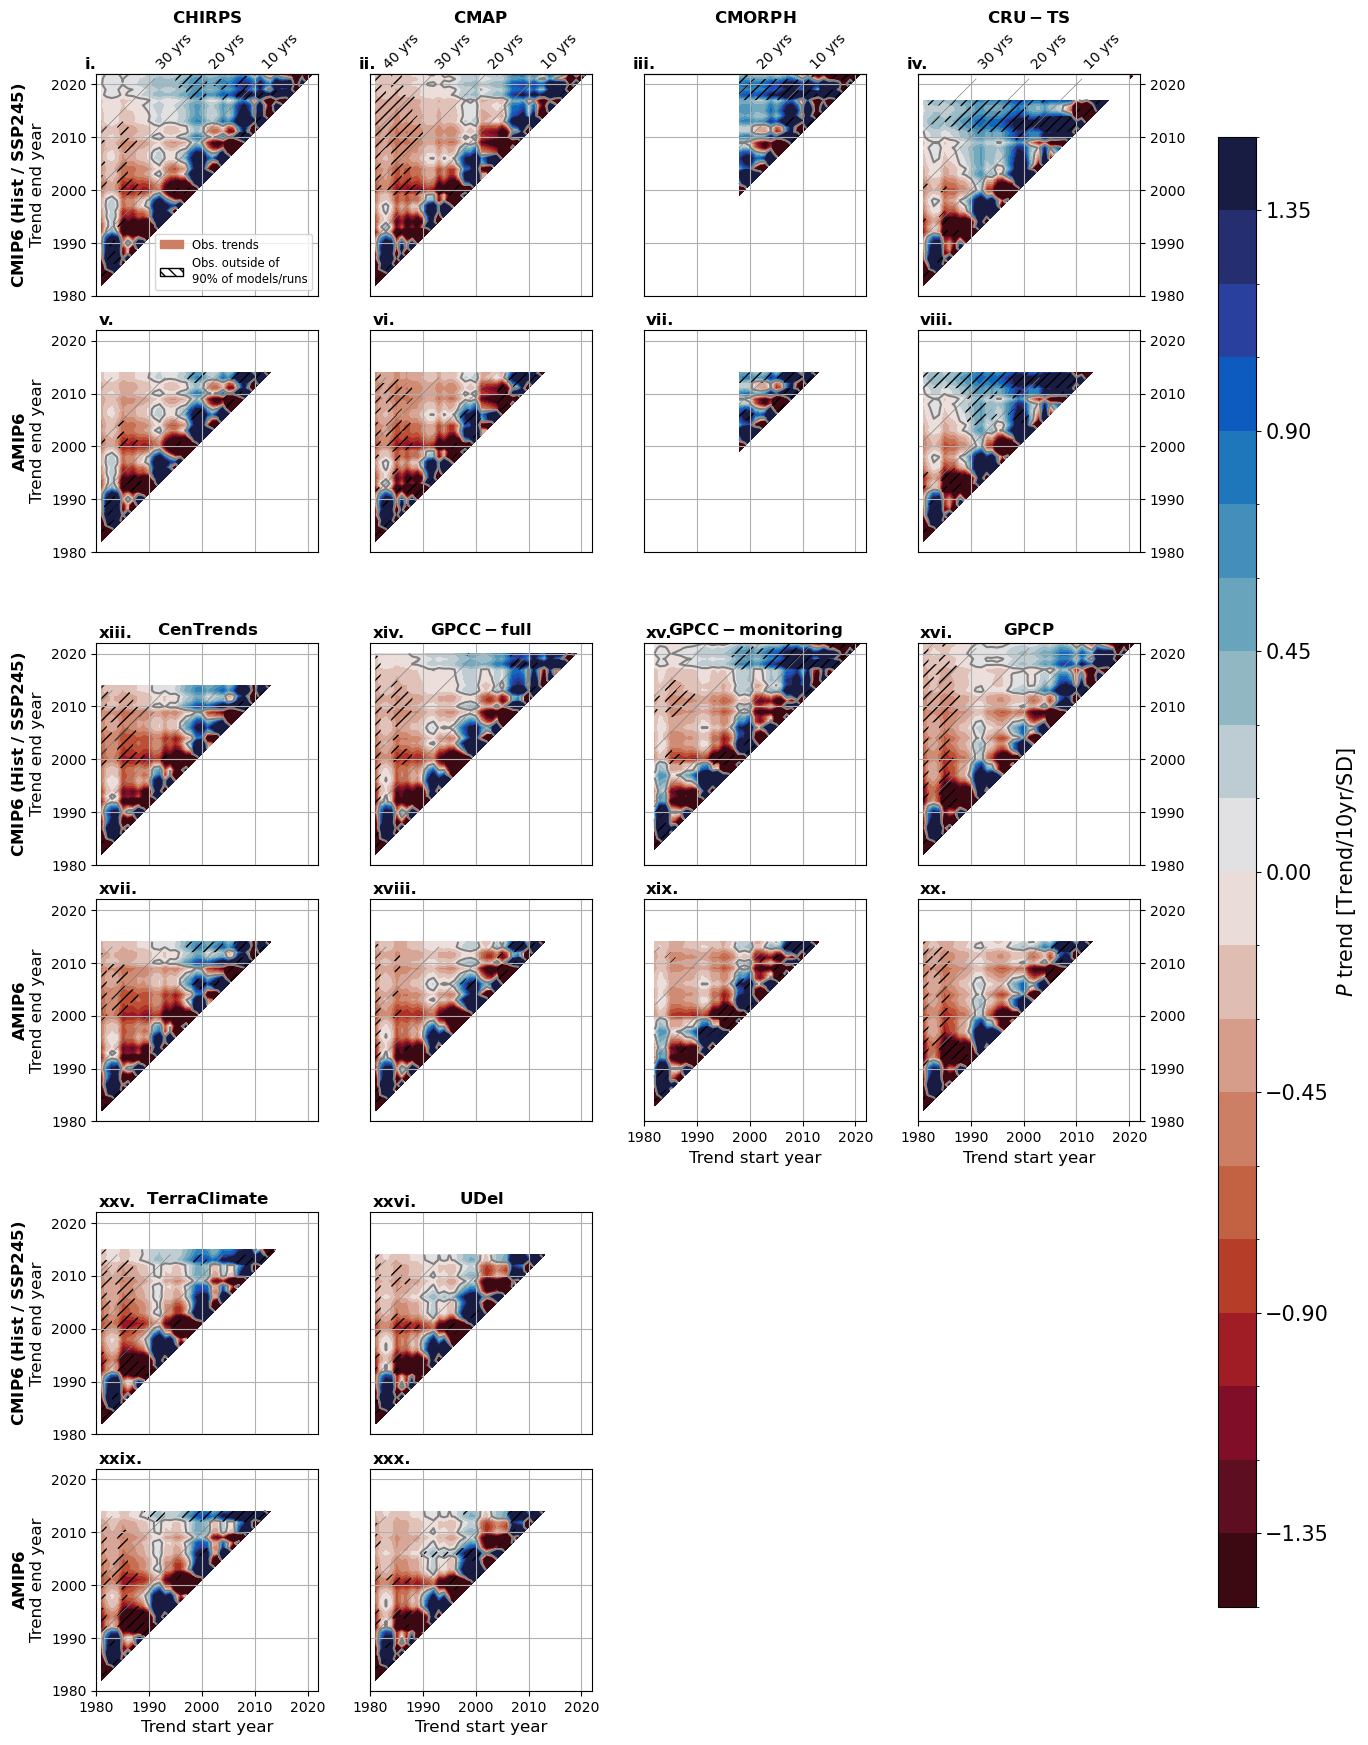

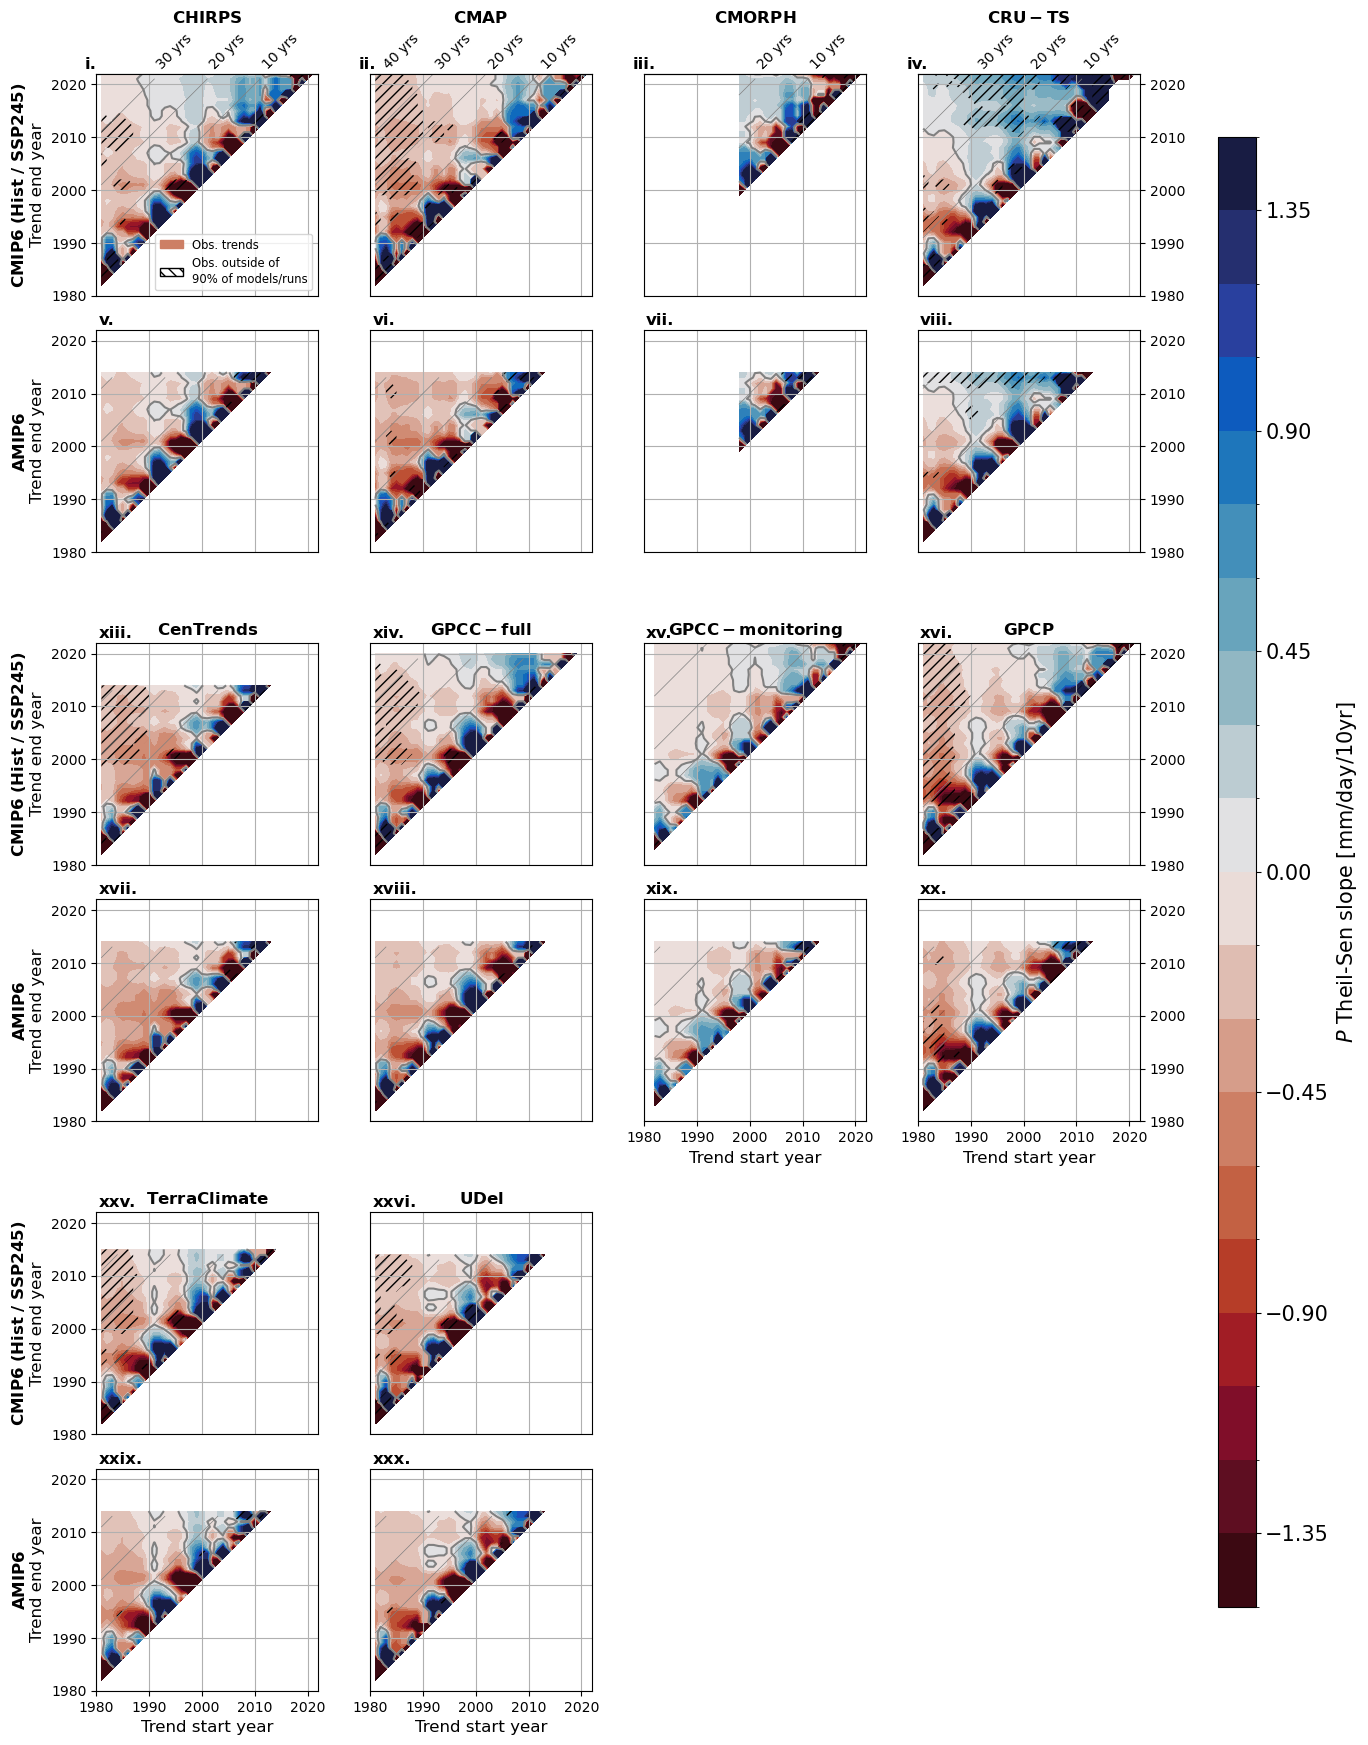

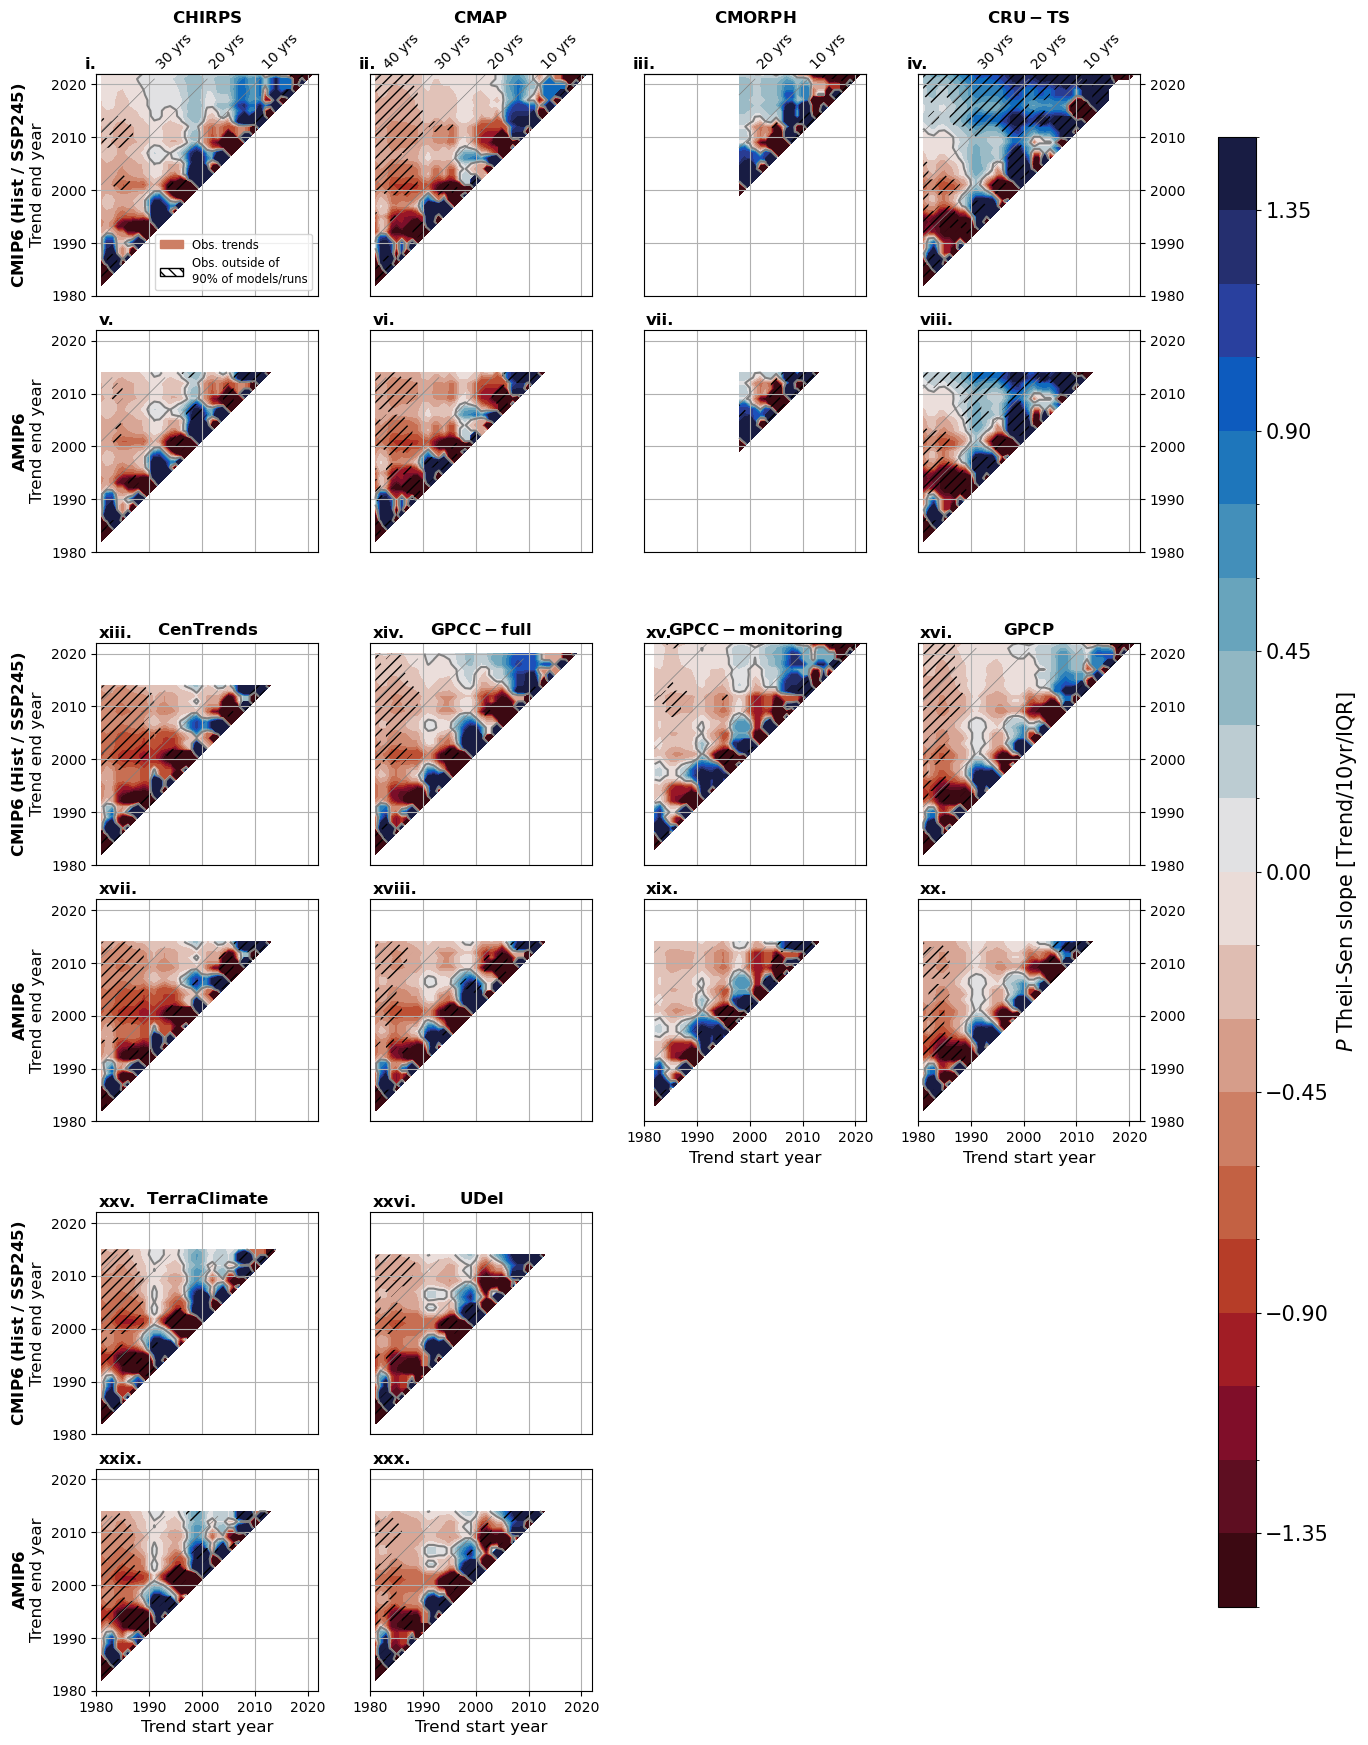

In [16]:
cbar_params = {'vmin':-1.5,'vmax':1.5,'cmap':cmocean.cm.balance_r,'levels':21}

for typ,num in zip(['levels','cv','tslevels','tscv'],np.arange(11,15)):
    plot_triangles(dss,
                   exps = ['hist-ssp245','amip'],
                   plot_type = typ,
                   ncol=4,
                   figsize=(15,21),
                   cbar_params = cbar_params,
                   save_fig=True,
                   output_fn=dir_list['figs']+'figureS'+str(num))

### NMME plots (not in manuscript)

/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS11_NMME.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS11_NMME.png saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS12_NMME.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS12_NMME.png saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS13_NMME.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS13_NMME.png saved!


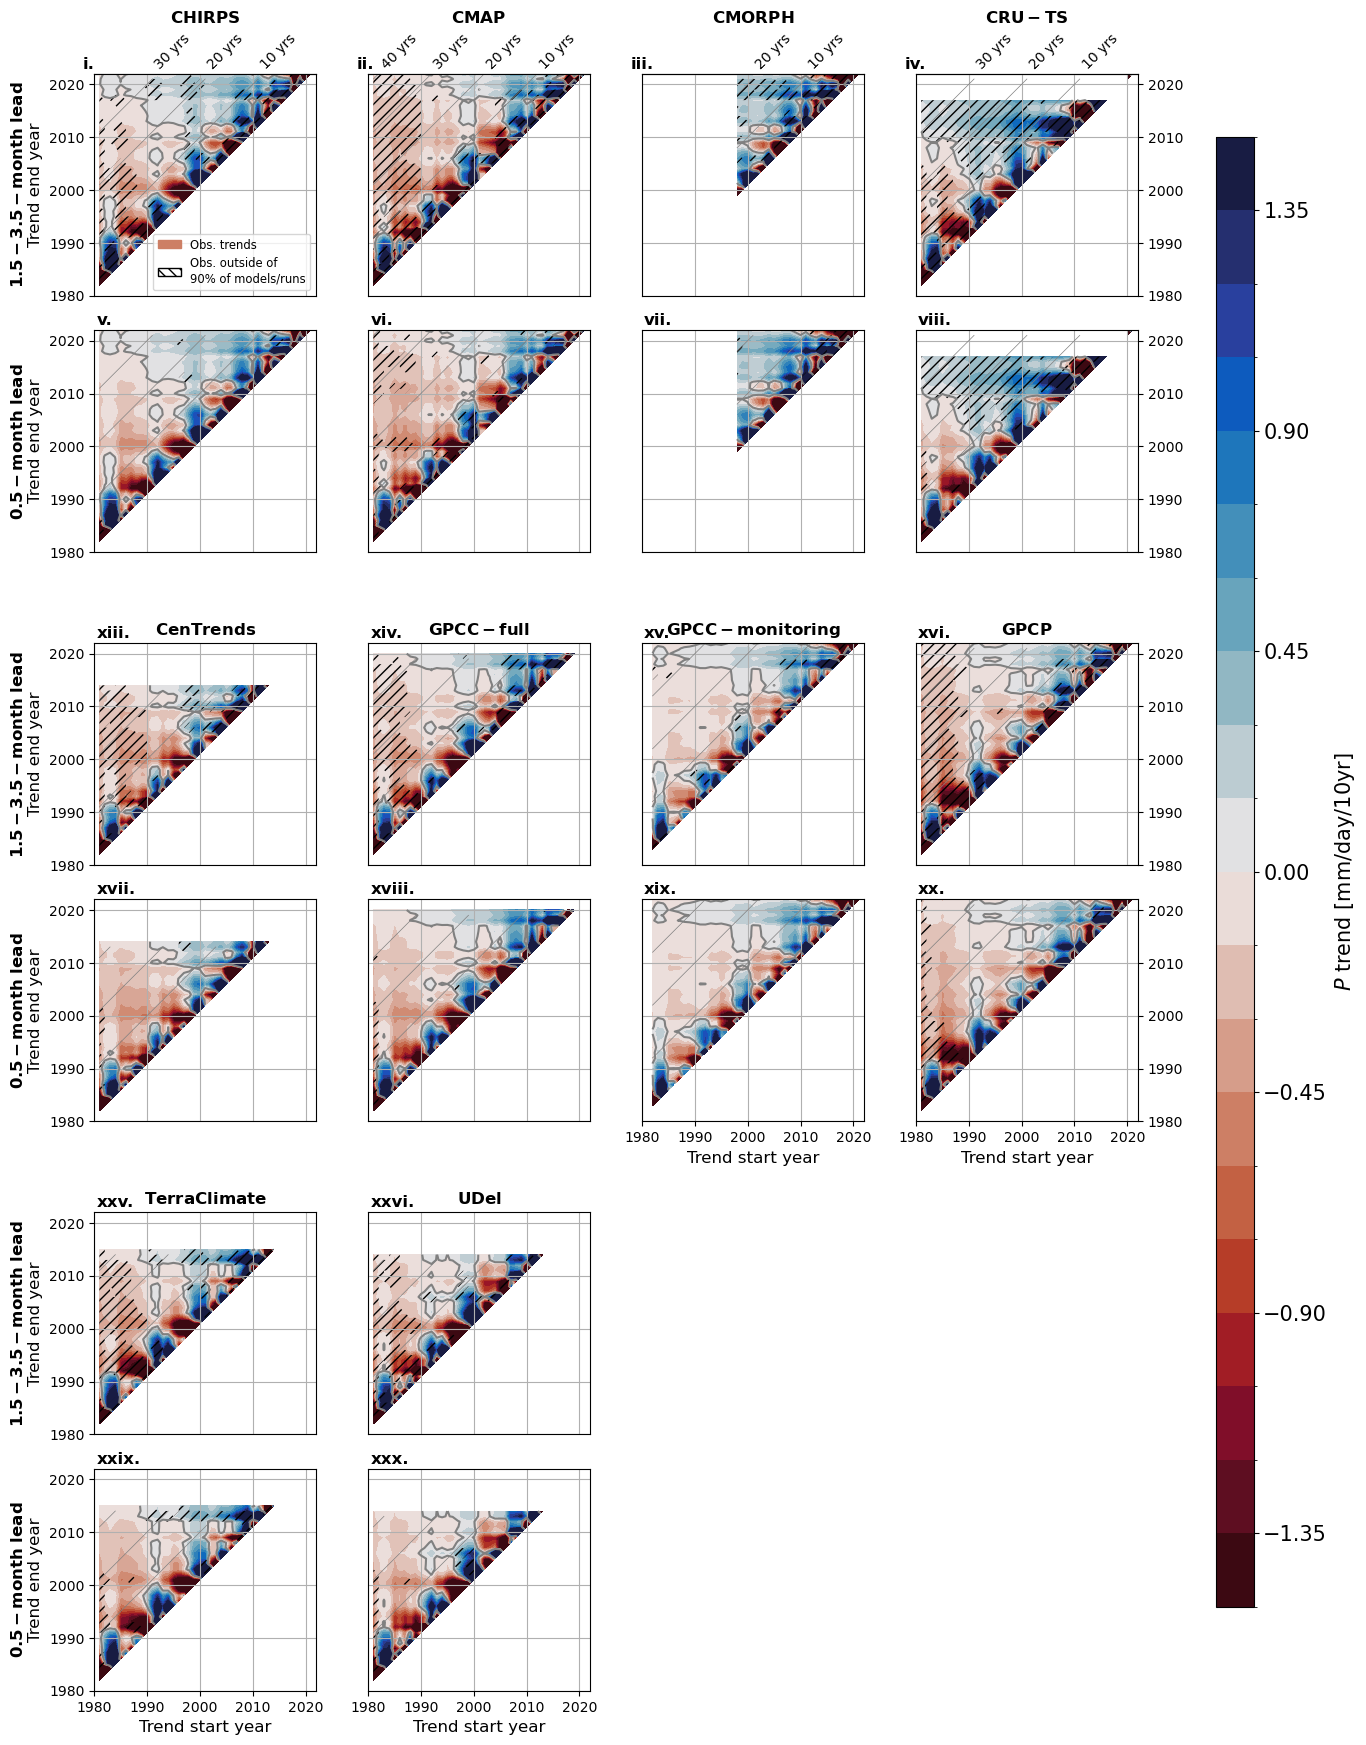

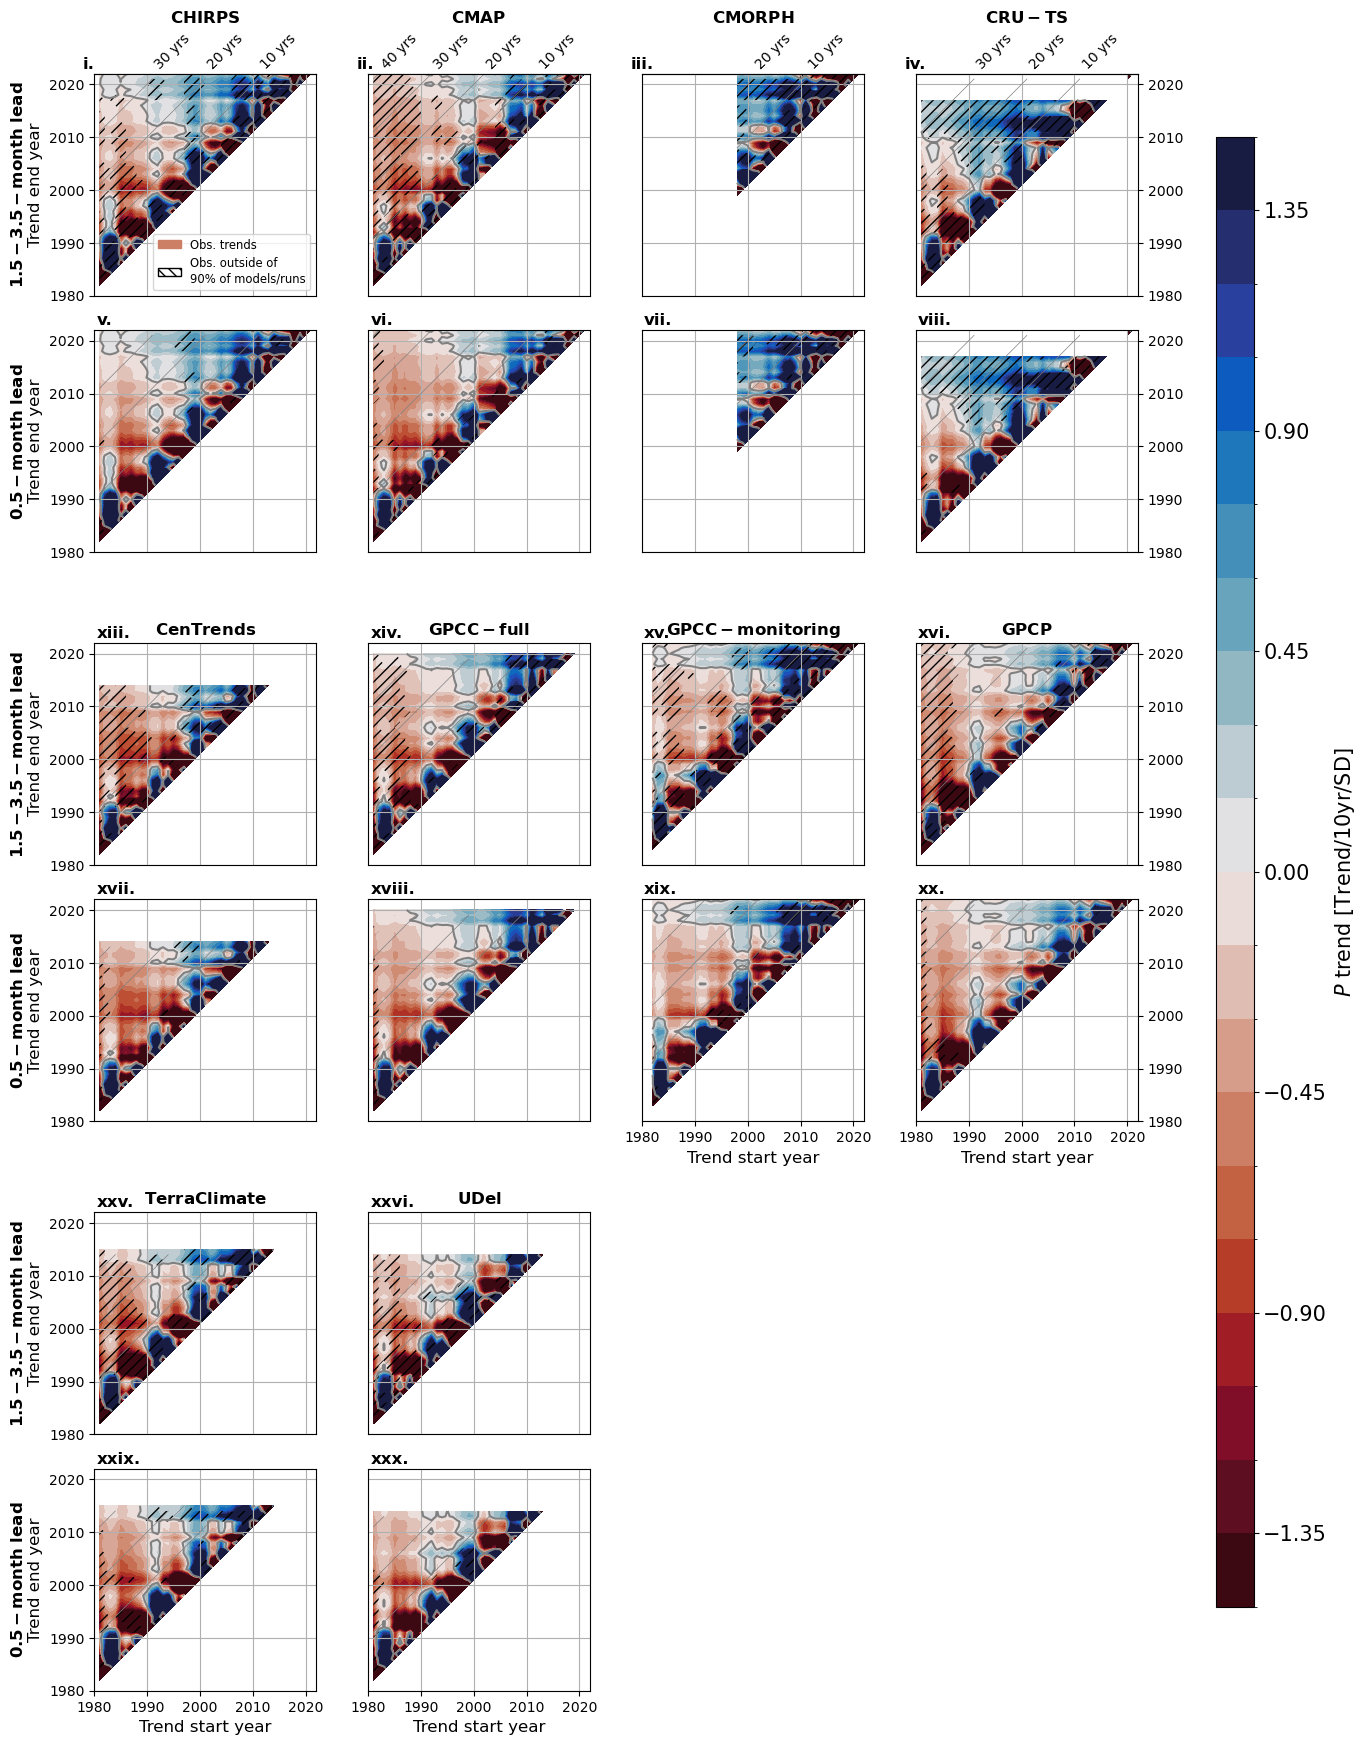

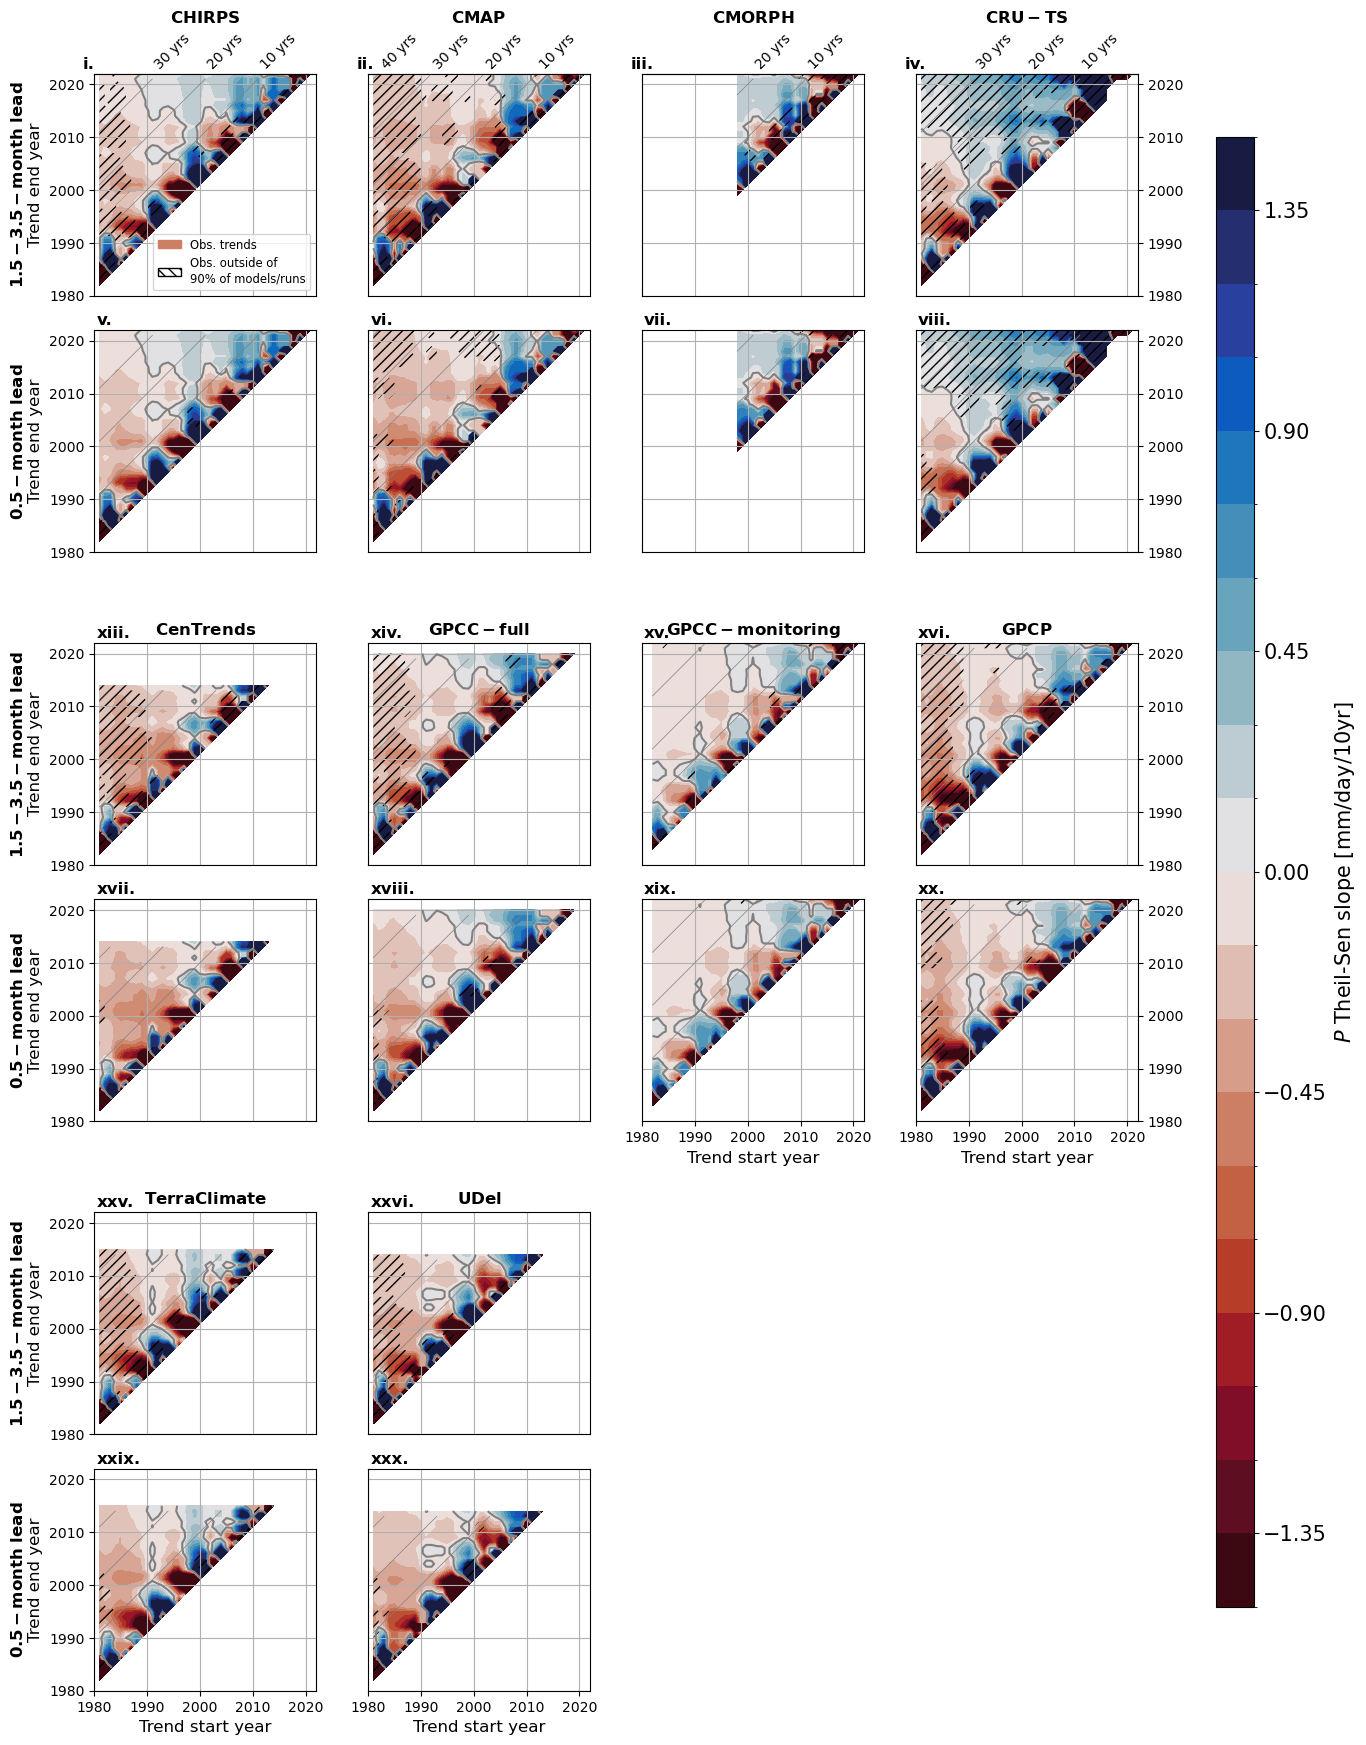

In [17]:
dss['hindcasts05lead'] = dss['hindcastsf'].sel(lead=0.5,drop=True)
dss['hindcasts1-3lead'] = dss['hindcastsf'].sel(lead=[1.5,2.5,3.5]).mean('lead')

cbar_params = {'vmin':-1.5,'vmax':1.5,'cmap':cmocean.cm.balance_r,'levels':21}

for typ,num in zip(['levels','cv','tslevels','tscv'],np.arange(11,14)):
    plot_triangles(dss,
                   exps = ['hindcasts1-3lead','hindcasts05lead'],
                   plot_type = typ,
                   ncol=4,
                   figsize=(15,21),
                   cbar_params = cbar_params,
                   save_fig=True,
                   output_fn=dir_list['figs']+'EXTRAfigureS'+str(num)+'_NMME')

## Alternate version using products going back to 1900

### Separately load just models / products with long-term data

In [18]:
dfs = get_filepaths(source_dir = 'proc')
dfs = dfs.query('varname == "prtrends" and suffix == "HoAfrica"')

In [19]:
def prep_for_concat(ds):
    # Helps make concatenation easier, because now the names of the runs
    # don't matter anymore (because we're not matching within models)
    
    if 'run' in ds.sizes:
        ds['run'] = np.arange(0,ds.sizes['run'])
    return ds

# Get filenames to load
fps = dict()
for exp in ['obs','amip','hist-none','hist-ssp245']:
    fps[exp] = dfs.query('exp == "'+exp+'"').groupby('model').apply(id_timeframe,'earliest','df',include_groups=False)


subset_params = {'start_year':slice(1900,2022),
                 'end_year':slice(1901,2023)}

# Load 
dss = dict()
for exp in fps:
    dss[exp] = dict()
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        for row in [row[1] for row in fps[exp].iterrows()]:
            # Load individually by model, to be able to run prep_for_concat
            # to avoid an unnecessarily bloated run dimension 
            dss[exp][row.name] = xr.open_dataset(row.path).sel(**subset_params)

    long_mods = [mod for mod in dss[exp] if dss[exp][mod].start_year.min().values < 1958]

    dss[exp] = {mod:dss[exp][mod][['prtrend','pr_tsslope','trend_length','pr_std','pr_iqr']].load() for mod in long_mods}

# Bring in model runs for whom there is only historical, 
# not SSP2.45 data
for mod in dss['hist-none']:
    if mod in dss['hist-ssp245']:
        runs_to_concat = [run for run in dss['hist-none'][mod].run.values
                          if run not in dss['hist-ssp245'][mod].run]
        if len(runs_to_concat)>0:
            dss['hist-ssp245'][mod] = xr.concat([dss['hist-ssp245'][mod],
                                                 dss['hist-none'].sel(run=runs_to_concat)],
                                                 dim='run')
    else:
        dss['hist-ssp245'][mod] = dss['hist-none'][mod]   
del dss['hist-none']

for exp in dss:
    # Concatenate into one ds across models
    dss[exp] = xr.concat([prep_for_concat(dss[exp][mod]) for mod in dss[exp]],
                         pd.Index([mod for mod in dss[exp]],name='model'))

    # Make sure to only keep needed variables and stop vars that are
    # unecessarily concatenated
    dss[exp]['trend_length'] = dss[exp]['trend_length'].mean('model')

    # Subset and load
    dss[exp] = dss[exp]

In [20]:
# Limit AMIP to just where most of the AMIP models have data
dss['amip'] = dss['amip'].where((~np.isnan(dss['amip'].prtrend.isel(region=0,season=0,drop=True).mean('run'))).sum('model')>4,
                 drop=True)

### Long triangle plots Figure S16 (and extra figures)

/dx02/kschwarz/project_data/future_stability/figures/figureS16.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS16.png saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS16_cv.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS16_cv.png saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS16_tslevels.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS16_tslevels.png saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS16_tscv.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS16_tscv.png saved!


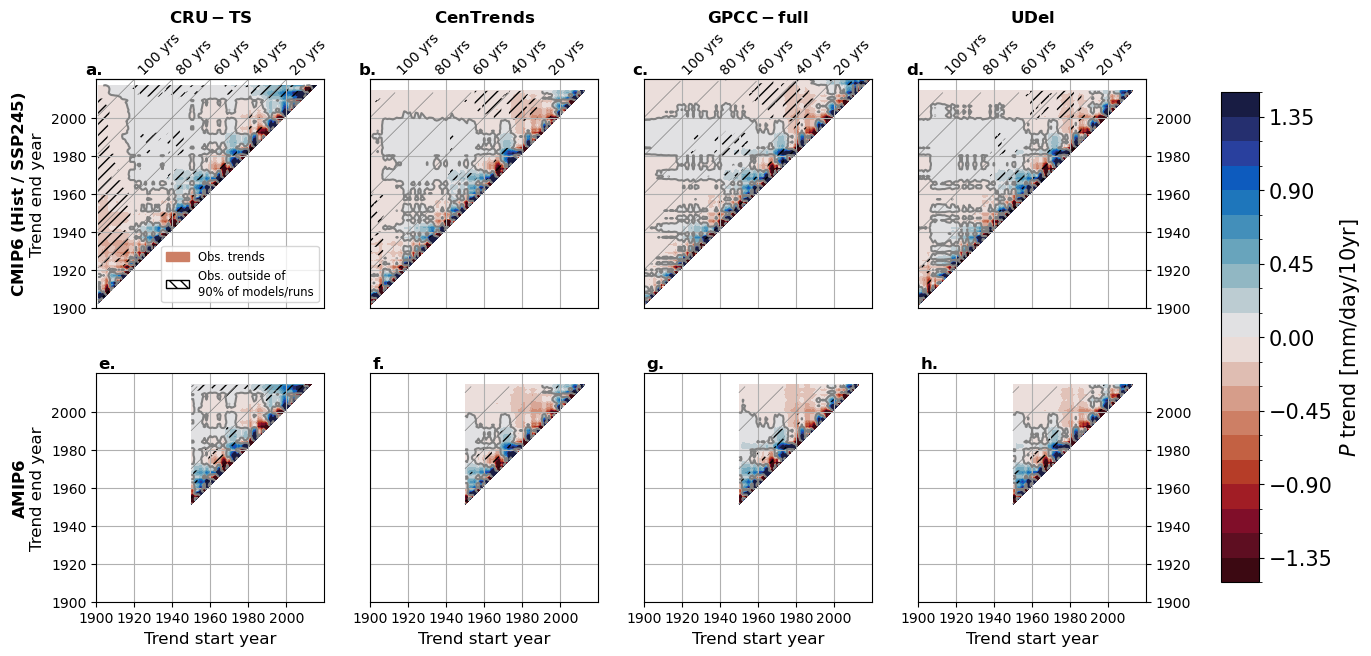

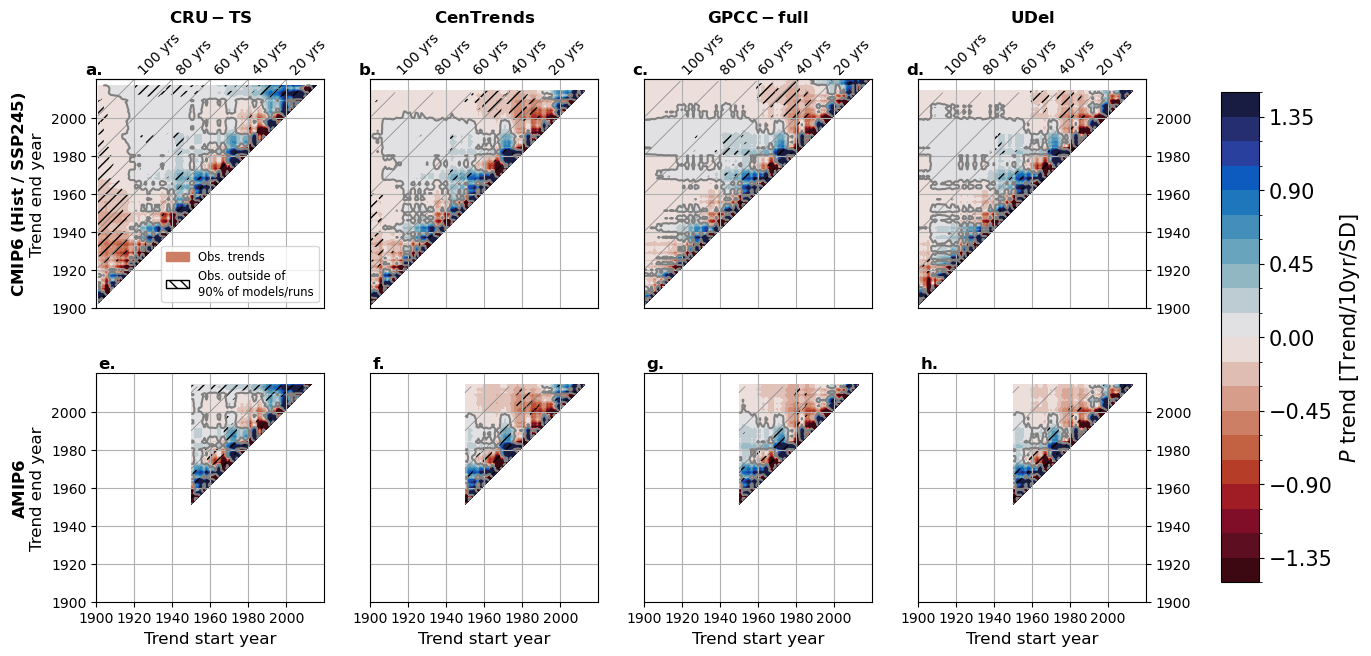

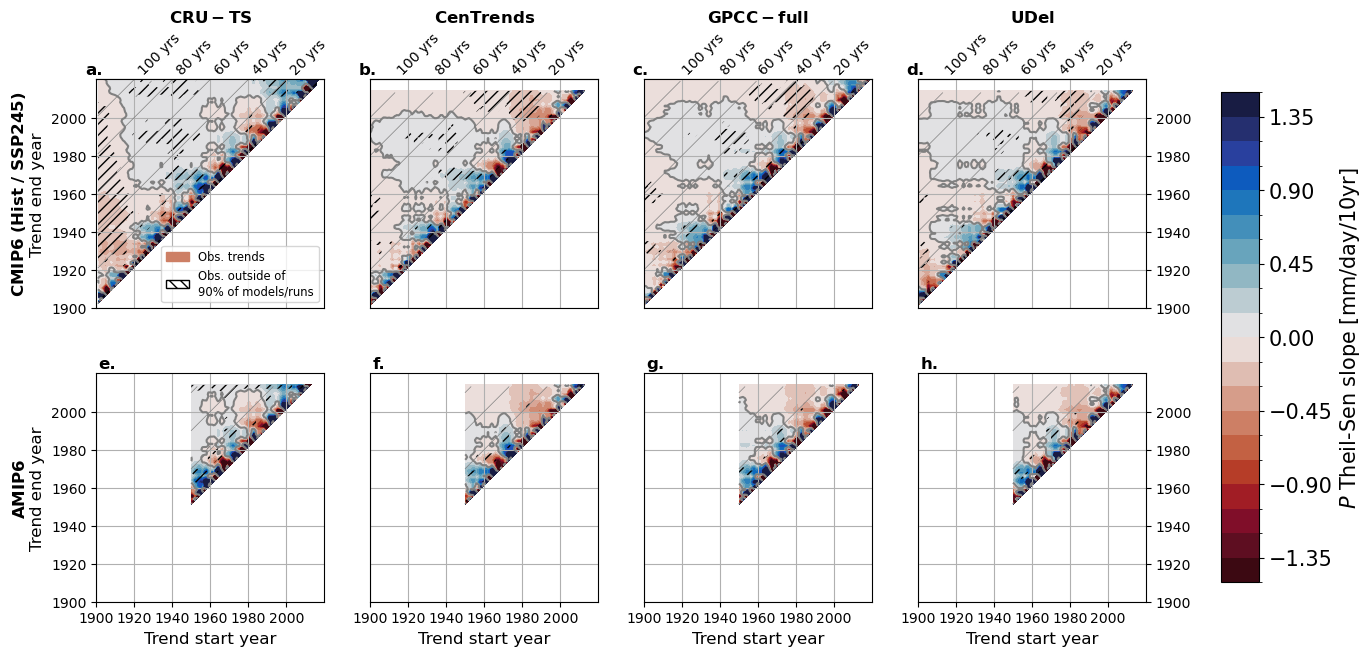

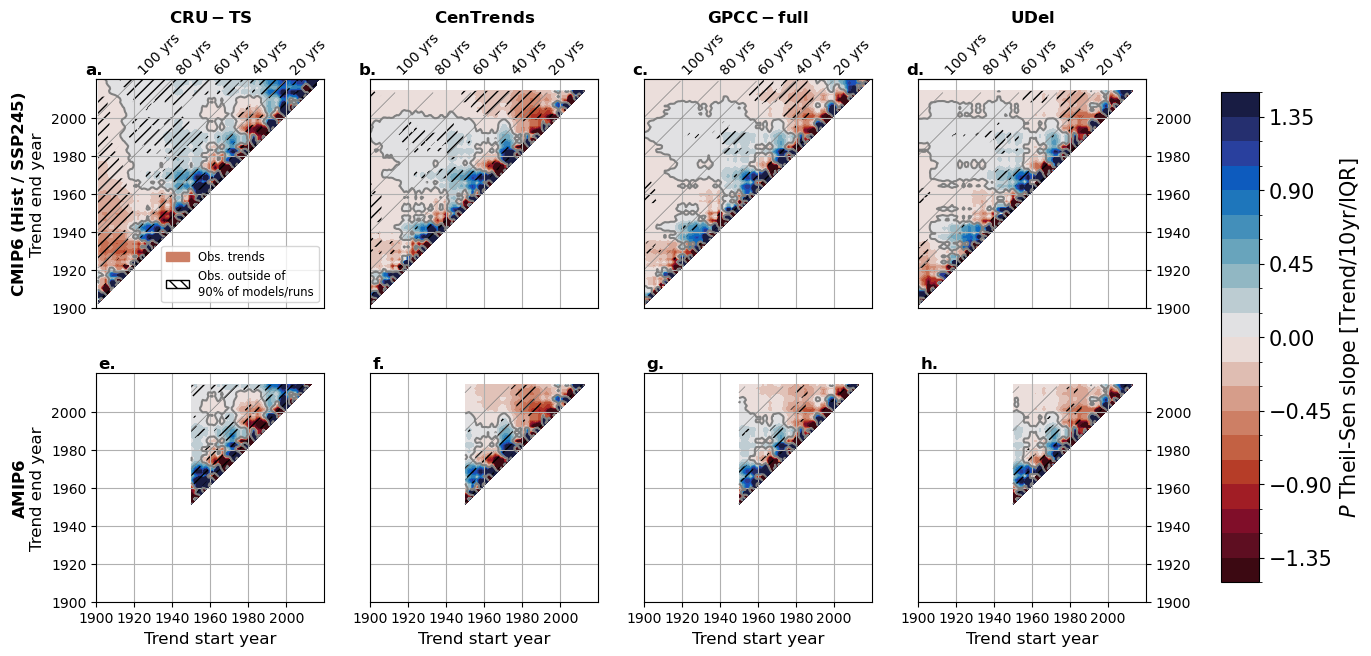

In [21]:
cbar_params = {'vmin':-1.5,'vmax':1.5,'cmap':cmocean.cm.balance_r,'levels':21}

for typ in ['levels','cv','tslevels','tscv']:
    if typ == 'levels':
        fn = 'figureS16'
    else:
        fn = 'EXTRAfigureS16_'+typ
    plot_triangles(dss,
                   exps = ['hist-ssp245','amip'],
                   plot_type = typ,
                   lims = [1900,2020],
                   trend_guide_spacing=20,
                   ncol=4,
                   figsize=(15,7),
                   cbar_params = cbar_params,
                   save_fig=True,
                   output_fn = dir_list['figs']+fn)
                   #output_fn = dir_list['figs']+'final_figS3vlong-'+typ+'_test')